# Analyzing SAT performance of public shcools in New York

#### Linna Ha & Chuck Zhu
#### Final Project for Data Bootcamp, Fall 2017

<div class="inline-block"> <img src="http://tribunacampeche.com/wp-content/uploads/2017/05/cenev.png" </div> 


## What determines the SAT scores of Public schools in New York?

### Background

The competition to get the best SAT scores is more and more [fierce](https://www.applerouth.com/blog/2015/01/14/raising-the-bar-with-the-new-sat/). Everyone wants to go to the best high school in order to get better scores on standardized tests such as the SAT. Students seldom know what is the real factor that determines a good school compared to a bad one. Their choice of high schools may not only decide which univerisity they are going to attend, but also maybe their entire future.

Public schools have so many different factors such as household income, teacher involvement, and school attendance. Since the problem is cruicial to our real life, yet unsolved, we want to explore what specific factors have the largest impact in the highest and lowest SAT scores in public high schools.

### Data Source

New York City provides alot of open data on the public education system. We will be using the most [recent high school quality report (2014-2015)](https://data.cityofnewyork.us/download/vrfr-9k4d/application%2Fvnd.ms-excel) which evaluates students performance and achievement based on SAT scores. The data, provided by Department of Education, contains a **district borough number (DBN)** column which classifies each district a school is located. It also includes over 30+ parameters such as economic need index, percentage in temporary housing, and safety of students. The dataset is in the from of an excel sheet with 6 tabs, which has been converted into a CSV and uploaded to github for easy access. 


### Libraries and API
There are 493 public schools in NYC. The dataset offers scores of 400 schools. Those with less than 10 students that take the SAT do no report scores. First, we chose the 2 excel tabs that provide the SAT scores and a file with variables that affect school envrionment.
Since the DBN is only used in New York, we used googlegeocoder API to match the DBN with their respective zip codes. **The geocode returns a full address of each DBN, which then we must scrape and split to only retain the borough and zipcode** After matching up the zipcode, we then further explore details about each district by merging the information with the U.S. Census API. 

Of the packages discussed in class, we will be using:
* `pandas` to create dataframes
* `numpy`
* `Census` API to merge income data with zipcodes
* `matplotlib` to graph analysis
* `statsmodels` to make linear regression analysis

New packages used are:
* `googlegeocoder` to align data with zipcodes 
* `geopandas` to create maps from a shapefile


In [3]:
# import packages 
import sys
import pandas as pd                   
import matplotlib.pyplot as plt      
import datetime as dt                  
import numpy as np                    
import seaborn as sns
import statistics
from scipy import stats

from googlegeocoder import GoogleGeocoder #to match up DBN with zipcode

from census import Census            
from us import states   

import statsmodels.api as sm
import statsmodels.formula.api as smf

import geopandas as gpd
from shapely.geometry import Point, Polygon
import fiona
import pysal as ps
%matplotlib inline                     

In [4]:
api_key = "670c60e67279b6125d24adb8a5ab50638d3f1ac7"
c = Census(api_key)

#### Our Goals

1. Look at highest and lowest scoring schools
2. Look at income differences
3. Look at differences amongst boroughs
4. Extract and analyze the most obvious data sets
5. Graph analysis on linear regression and distribution
6. Find out what factors most influence the school's performance

### Cleaning and Merging Datasets

In [68]:
part_1 ="https://raw.githubusercontent.com/chuckzhuisme/my_first_repository/"
part_2 = "master/Copy%20of%202014_2015_HS_SQR_Scores.csv"
part_3 = 'master/Copy%20of%202014_2015_HS_SQR_Results_Summary.csv'
hs_scores = part_1 + part_2
hs_summary = part_1 + part_3
clean_file = "https://raw.githubusercontent.com/linnaha/NYCdata/master/sat_zip_clean.csv"
var="https://raw.githubusercontent.com/chuckzhuisme/my_first_repository/" + \
"master/Copy%20of%202014_2015_HS_SQR_Results_Summary.csv"

satdf = pd.read_csv(hs_scores, encoding='latin-1') #file with standardized test scores
variabledf = pd.read_csv(var, encoding='latin-1') #file with performance variables
satdata = pd.read_csv(clean_file, encoding='latin-1') #seperate file with just zipcodes and sat scores
summary = pd.read_csv(hs_summary, encoding='latin-1')
satdf.head()

,DBN,School Name,Average Score Regents Algebra,Percentage Passing Regents Algebra,Percentage at college ready threshold Regents Algebra,Average Score Regents Geometry,Percentage Passing Regents Geometry,Percentage at college ready threshold Regents Geometry,Average Score Regents Algebra 2/Trig,Percentage Passing Regents Algebra 2/Trig,...,Percentage Attaining English College Readiness Standard (6 year),College and Career Preparatory Course Index,"Percentage Scoring 65+ on Alg2, MathB, Chem, or Phys Regents Exam",Percentage Scoring 3+ on any AP Exam,Percentage Scoring 4+ on any IB Exam,Percentage Earning a Diploma with a CTE Endorsement,Percentage Passing an Industry-Recognized Technical Assessment,Percentage Earning a Diploma with an Arts Endorsement,Percentage Earning a Grade of 'C' or Higher for College Credit,Percentage Passing a CPCC Course
0,01M292,Henry Street School for International Studies,64.0,52.4%,6.3%,58.0,33.3%,5.6%,NaN,NaN,...,36.0%,33.3%,1.4%,1.4%,0.0%,0.0%,0.0%,0.0%,1.4%,0.0%
1,01M448,University Neighborhood High School,64.0,55.0%,4.2%,68.0,59.8%,19.5%,62.0,53.3%,...,53.9%,67.5%,27.7%,41.0%,0.0%,0.0%,0.0%,0.0%,65.1%,0.0%
2,01M450,East Side Community School,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,71.8%,38.6%,0.0%,5.7%,0.0%,0.0%,0.0%,0.0%,9.1%,31.8%
3,01M509,Marta Valle High School,61.0,40.7%,2.8%,66.0,63.2%,7.9%,74.0,68.4%,...,35.6%,20.8%,11.9%,2.0%,0.0%,0.0%,0.0%,0.0%,14.9%,0.0%
4,01M539,"New Explorations into Science, Technology and ...",80.0,91.5%,53.2%,83.0,96.8%,68.6%,80.0,87.8%,...,98.5%,99.2%,99.2%,81.1%,0.0%,0.0%,0.0%,0.0%,11.5%,0.0%


There are more than 90 columns. We will make a copy of the dataframe with the just the columns of the SAT scores and DBN. 

In [6]:
df = satdata[['DBN', 'School Name', 'Average Score SAT Math','Average Score SAT Critical Reading', \
             'Average Score SAT Writing']].copy()
col_list= list(df)
col_list.remove('DBN')
col_list.remove('School Name')
col_list
df['Average SAT Score for Three sections'] = df[col_list].sum(axis=1)
df.head()

,DBN,School Name,Average Score SAT Math,Average Score SAT Critical Reading,Average Score SAT Writing,Average SAT Score for Three sections
0,01M292,Henry Street School for International Studies,410,406,381,1197
1,01M448,University Neighborhood High School,437,355,352,1144
2,01M450,East Side Community School,454,428,445,1327
3,01M509,Marta Valle High School,438,413,394,1245
4,01M539,"New Explorations into Science, Technology and ...",657,601,601,1859


Secondly, we will merge the dataframe with the second excel tab which includes different quality metrics.

In [81]:
#This dataset has 40 columns. Let's choose the ones we need.

rating = variabledf[['DBN', 'School Name', 'Quality Review - How clearly are high expectations communicated to students and staff?', \
        'Quality Review - How interesting and challenging is the curriculum?', \
        'Quality Review - How effective is the teaching and learning?', \
        'Rigorous Instruction Rating','Collaborative Teachers Rating', \
        'Supportive Environment Rating', 'Strong Family-Community Ties Rating', \
        'Effective School Leadership Rating']].copy()
rating.head()

,DBN,School Name,Quality Review - How clearly are high expectations communicated to students and staff?,Quality Review - How interesting and challenging is the curriculum?,Quality Review - How effective is the teaching and learning?,Rigorous Instruction Rating,Collaborative Teachers Rating,Supportive Environment Rating,Strong Family-Community Ties Rating,Effective School Leadership Rating
0,01M292,Henry Street School for International Studies,Developing,Developing,Developing,Not Meeting Target,Approaching Target,Approaching Target,Approaching Target,Approaching Target
1,01M448,University Neighborhood High School,Proficient,Well Developed,Proficient,Meeting Target,Meeting Target,Exceeding Target,Meeting Target,Exceeding Target
2,01M450,East Side Community School,Well Developed,Well Developed,Proficient,Exceeding Target,Exceeding Target,Exceeding Target,Exceeding Target,Exceeding Target
3,01M509,Marta Valle High School,Proficient,Developing,Developing,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Approaching Target
4,01M539,"New Explorations into Science, Technology and ...",Proficient,Well Developed,Well Developed,Exceeding Target,Approaching Target,Meeting Target,Approaching Target,Not Meeting Target


In [82]:
#This dataset has 40 columns. Let's choose the ones we need.

numerical = summary[['DBN', 'School Name', 'Enrollment','Student Attendance Rate', \
        'Economic Need Index', 'Average Grade 8 English Proficiency', 'Average Grade 8 Math Proficiency', \
        'Percent English Language Learners', \
        'Rigorous Instruction - Percent Positive', 'Percent Asian', 'Percent Black', \
        'Percent Hispanic', 'Percent White']].copy()

numerical.head()

,DBN,School Name,Enrollment,Student Attendance Rate,Economic Need Index,Average Grade 8 English Proficiency,Average Grade 8 Math Proficiency,Percent English Language Learners,Rigorous Instruction - Percent Positive,Percent Asian,Percent Black,Percent Hispanic,Percent White
0,01M292,Henry Street School for International Studies,255,76.6%,83.2%,2.18,2.06,12.7%,72%,13.2%,24.4%,56.6%,3.9%
1,01M448,University Neighborhood High School,304,88.0%,81.2%,2.27,2.37,19.4%,85%,29.9%,25.0%,41.1%,3.3%
2,01M450,East Side Community School,666,93.8%,61.0%,2.66,2.63,1.8%,92%,9.4%,22.1%,57.9%,8.3%
3,01M509,Marta Valle High School,363,76.8%,76.7%,2.28,2.09,9.1%,86%,5.8%,39.9%,51.2%,2.5%
4,01M539,"New Explorations into Science, Technology and ...",1735,95.2%,25.7%,3.50,3.53,0.2%,81%,38.5%,13.3%,18.0%,28.6%


In [83]:
# Now lets merge the two dataframes together with DBN
del numerical['School Name']
combo_num = pd.merge(df, numerical,# left df, right df
                 on='DBN',       # link with cntry
                 how='left',        # add to left...does this matter here?
                 indicator=True)  # Tells us what happend
combo_num.head()

,DBN,School Name,Average Score SAT Math,Average Score SAT Critical Reading,Average Score SAT Writing,Average SAT Score for Three sections,Enrollment,Student Attendance Rate,Economic Need Index,Average Grade 8 English Proficiency,Average Grade 8 Math Proficiency,Percent English Language Learners,Rigorous Instruction - Percent Positive,Percent Asian,Percent Black,Percent Hispanic,Percent White,_merge
0,01M292,Henry Street School for International Studies,410,406,381,1197,255,76.6%,83.2%,2.18,2.06,12.7%,72%,13.2%,24.4%,56.6%,3.9%,both
1,01M448,University Neighborhood High School,437,355,352,1144,304,88.0%,81.2%,2.27,2.37,19.4%,85%,29.9%,25.0%,41.1%,3.3%,both
2,01M450,East Side Community School,454,428,445,1327,666,93.8%,61.0%,2.66,2.63,1.8%,92%,9.4%,22.1%,57.9%,8.3%,both
3,01M509,Marta Valle High School,438,413,394,1245,363,76.8%,76.7%,2.28,2.09,9.1%,86%,5.8%,39.9%,51.2%,2.5%,both
4,01M539,"New Explorations into Science, Technology and ...",657,601,601,1859,1735,95.2%,25.7%,3.50,3.53,0.2%,81%,38.5%,13.3%,18.0%,28.6%,both


In [86]:
# Now lets merge the two dataframes together with DBN
del rating['School Name']
combo_rate = pd.merge(df, rating,# left df, right df
                 on='DBN',       # link with cntry
                 how='left',        # add to left...does this matter here?
                 indicator=True)  # Tells us what happend
combo_rate.head()

,DBN,School Name,Average Score SAT Math,Average Score SAT Critical Reading,Average Score SAT Writing,Average SAT Score for Three sections,Quality Review - How clearly are high expectations communicated to students and staff?,Quality Review - How interesting and challenging is the curriculum?,Quality Review - How effective is the teaching and learning?,Rigorous Instruction Rating,Collaborative Teachers Rating,Supportive Environment Rating,Strong Family-Community Ties Rating,Effective School Leadership Rating,_merge
0,01M292,Henry Street School for International Studies,410,406,381,1197,Developing,Developing,Developing,Not Meeting Target,Approaching Target,Approaching Target,Approaching Target,Approaching Target,both
1,01M448,University Neighborhood High School,437,355,352,1144,Proficient,Well Developed,Proficient,Meeting Target,Meeting Target,Exceeding Target,Meeting Target,Exceeding Target,both
2,01M450,East Side Community School,454,428,445,1327,Well Developed,Well Developed,Proficient,Exceeding Target,Exceeding Target,Exceeding Target,Exceeding Target,Exceeding Target,both
3,01M509,Marta Valle High School,438,413,394,1245,Proficient,Developing,Developing,Approaching Target,Approaching Target,Approaching Target,Approaching Target,Approaching Target,both
4,01M539,"New Explorations into Science, Technology and ...",657,601,601,1859,Proficient,Well Developed,Well Developed,Exceeding Target,Approaching Target,Meeting Target,Approaching Target,Not Meeting Target,both


Now that we have the merged data, we can start analyzing. 

## Highest and Lowest Scoring Schools

Let's take a look at the difference in scores between the top and bottom of the dataset.

In [9]:
#we may want to rename columns
#satdf = satdf.rename(columns={'School Name':'name',"Average Score SAT Math":"avg_math","Average Score SAT Critical Reading":"avg_read","Average Score SAT Writing":"avg_write","Average SAT Score for Three sections":"avg_sat"})
satdata = satdata.rename(columns={'School Name':'name',"Average Score SAT Math":"avg_math","Average Score SAT Critical Reading":"avg_read","Average Score SAT Writing":"avg_write","Average SAT Score for Three sections":"avg_sat"})

In [10]:
df.shape

(400, 6)

Of the 493 schools, 400 schools are reported with SAT scores.

In [11]:
schools = combo.groupby('School Name')
sat_avg2 = schools['Average SAT Score for Three sections'].agg([np.sum, np.mean, np.std]).sort_values(['mean'],
           ascending=False)
#nb_dist = area2['avg_dist'].agg([np.sum, np.mean, np.std])

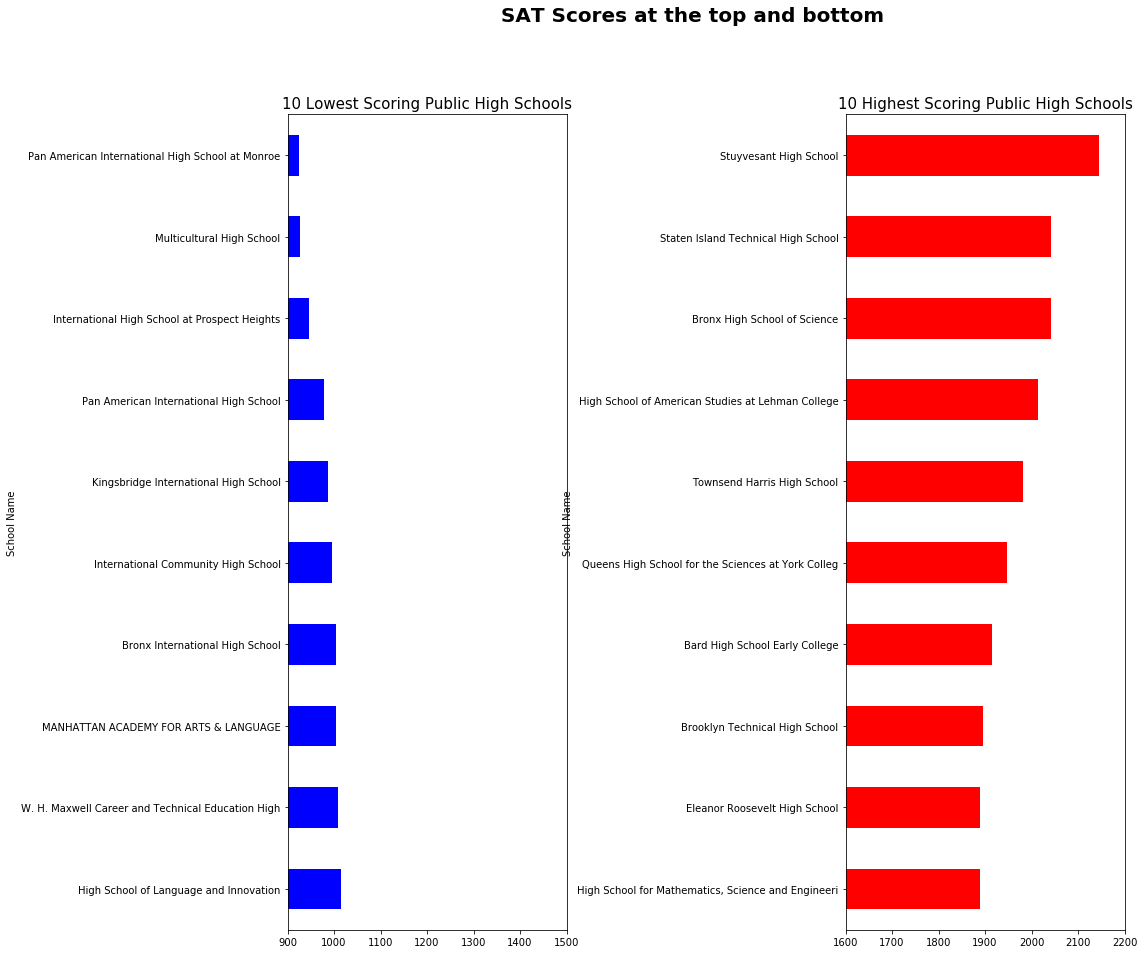

In [41]:
fig, ax = plt.subplots(1,2,figsize=(15, 15))
fig.suptitle('SAT Scores at the top and bottom', fontsize=20, fontweight='bold')
fig.subplots_adjust(wspace=1)
sat_avg2['mean'].head(10).plot(kind='barh', ax=ax[1], color='r')
sat_avg2['mean'].tail(10).plot(kind='barh', ax=ax[0], color='b')
plt.gca().invert_yaxis() #show the highest and lowest score on top

ax[0].set_title("10 Lowest Scoring Public High Schools", fontsize=15)
ax[1].set_title("10 Highest Scoring Public High Schools", fontsize=15)
ax[0].set_xlim(900,1500)
ax[1].set_xlim(1600,2200)

plt.show()

### What are some causes for the disparity between scores?

Let's first take a look at income. We will use the U.S. Census API that we called before and merge it with our sat dataframe.

In [24]:
satdf_top = satdata[["name","avg_math","avg_read","avg_write","avg_sat","borough","zip"]].copy()
satdf_top.sort_values(by="avg_sat",ascending=False, inplace=True)

In [28]:
code = ("B19013_001E") 
#code for median houshold income
    
zip_2015 = pd.DataFrame(c.acs5.get(code, 
                                         {'for': "zip code tabulation area:*"}, year=2015))
#zip_2015.head()
#the * will get all the zipcodes. Then we will merge so that only the zipcodes that are in  our dataset will appear.

In [29]:
zip_2015 = zip_2015.rename(columns={'zip code tabulation area':'zip', 
                                    'B19013_001E':'avg_income'})
zip_2015.head()

,avg_income,zip
0,10816.0,00601
1,16079.0,00602
2,16804.0,00603
3,12512.0,00606
4,17475.0,00610


In order to merge the datasets, we must first change the dtypes to be the same.

In [30]:
zip_2015['zip'] = zip_2015['zip'].astype(str).astype(int) 

In [31]:
income_satdf = pd.merge(satdf_top,zip_2015,   
                 how='left',      # will merge with only the data in the left, which is our satdf_top
                 on='zip',       
                 indicator=True) 
income_satdf.head()

,name,avg_math,avg_read,avg_write,avg_sat,borough,zip,avg_income,_merge
0,Stuyvesant High School,754,697,693,2144,New_York,10282,250001.0,both
1,Bronx High School of Science,714,660,667,2041,Bronx,10468,34784.0,both
2,Staten Island Technical High School,711,660,670,2041,Staten_Island,10306,79686.0,both
3,High School of American Studies at Lehman College,669,672,672,2013,Bronx,10468,34784.0,both
4,Townsend Harris High School,680,640,661,1981,Queens,11367,56557.0,both


In [32]:
income_satdf.tail()

,name,avg_math,avg_read,avg_write,avg_sat,borough,zip,avg_income,_merge
395,Kingsbridge International High School,366,311,310,987,Bronx,10468,34784.0,both
396,Pan American International High School,340,320,318,978,Queens,11373,47588.0,both
397,International High School at Prospect Heights,344,302,300,946,Brooklyn,11225,44911.0,both
398,Multicultural High School,319,323,284,926,Brooklyn,11208,35698.0,both
399,Pan American International High School at Monroe,317,315,292,924,Bronx,10472,29308.0,both


In [33]:
income_satdf["avg_income"].head(10).mean()

81275.44444444444

In [34]:
income_satdf["avg_income"].tail(10).mean()

43274.0

The lowest scoring school, Pan American, has an average household income of $30,000.

Meanwhile, the zipcode of highest scoring school, Stuyvesant, has an average household income of ** $250,000.** 

The top 10 highest scoring schools have an average of $80,000, which is almost double the average income of the lowest scoring schools. 

One interesting thing to note is that the second highest scoring school, Bronx High School of Science, is in the same area as the one of the lowest scoring schools, Kingsbridge. 

** Does this finding resonate in all the schools? Let's look at a map. **

## Mapping SAT Scores

Using geopandas, we can create a map of the New York City area and plot our dataset onto it. First, we had to get a [shape file](https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data) which contains the data of the district and zip code boundaries. Once it is downloaded, we can source it into the notebook.

Shape File Path:

In [42]:
path = "/Users/zhujunhan/Downloads/"

zip_file = path + "ZIP_CODE_040114" #this is for mac users

In [43]:
test = gpd.read_file(zip_file)
zipmap = pd.DataFrame(test)

In [44]:
test = test.rename(columns={'ZIPCODE':'zip'})
test['zip'] = test['zip'].astype(str).astype(int) #must change dtype from object to integer
test["zip"].dtypes #now that the zip is an integer, we can merge 

dtype('int64')

In [45]:
zipmap  = test.merge(income_satdf, on='zip', how = "outer")
zipmap.head()

,zip,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,SHAPE_LEN,geometry,name,avg_math,avg_read,avg_write,avg_sat,borough,avg_income,_merge
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,...,0.0,"POLYGON ((1038098.251871482 188138.3800067157,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",Pathways in Technology Early College High Scho...,446.0,442.0,410.0,1298.0,Brooklyn,34701.0,both
2,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",KIPP AMP Charter School,452.0,411.0,418.0,1281.0,Brooklyn,34701.0,both
3,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",Academy for Health Careers,406.0,405.0,396.0,1207.0,Brooklyn,34701.0,both
4,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,...,0.0,"POLYGON ((1001613.712964058 186926.4395172149,...",Boys and Girls High School,399.0,392.0,394.0,1185.0,Brooklyn,34701.0,both


In [58]:
hr90 = zipmap["avg_income"]
hr90q5 = ps.Quantiles(hr90, k=5)
hr90q5

hr90.bins()

/Users/zhujunhan/anaconda/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in greater
  binIds += (x > l) * (x <= r) * k
/Users/zhujunhan/anaconda/lib/python3.6/site-packages/pysal/esda/mapclassify.py:267: RuntimeWarning: invalid value encountered in less_equal
  binIds += (x > l) * (x <= r) * k
/Users/zhujunhan/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3858: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


AttributeError: 'Series' object has no attribute 'bins'

/Users/zhujunhan/anaconda/lib/python3.6/site-packages/matplotlib/colors.py:496: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


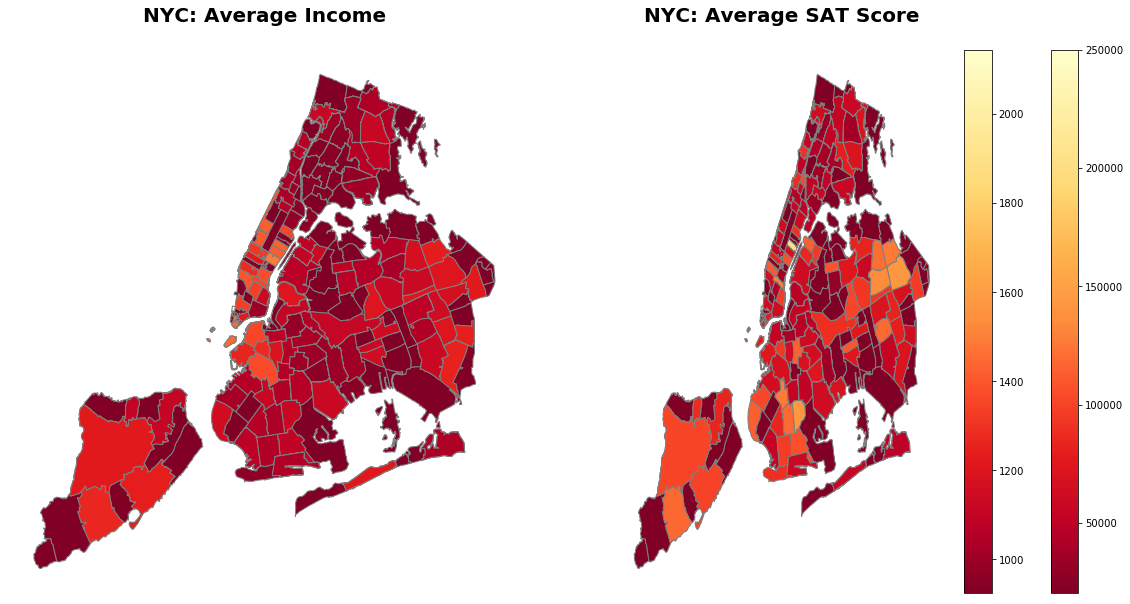

In [47]:
fig, ax = plt.subplots(1,2,figsize = (20,10))

# First create the map for NYC
######################################################################################
# Then lets create the map for income

zipmap.plot(ax = ax[0], edgecolor='tab:grey', k =9,
             column='avg_income',
            cmap='YlOrRd_r', alpha = 1.0, legend = True )


######################################################################################    

ax[0].spines["right"].set_visible(False)
ax[0].spines["top"].set_visible(False)
ax[0].spines["left"].set_visible(False)
ax[0].spines["bottom"].set_visible(False)

ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[0].set_title("NYC: Average Income\n", fontsize=20, fontweight="bold")

######################################################################################
######################################################################################
# Then lets create the map for SAT scores

zipmap.plot(ax = ax[1], edgecolor='tab:grey', 
                column='avg_sat', cmap='YlOrRd_r', 
            alpha = 1.0, legend=True, k=9)

######################################################################################
  
    
ax[1].spines["right"].set_visible(False)
ax[1].spines["top"].set_visible(False)
ax[1].spines["left"].set_visible(False)
ax[1].spines["bottom"].set_visible(False)

ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

ax[1].set_title("NYC: Average SAT Score\n",fontsize=20, fontweight="bold")


plt.show()

We see that there definitley is a role of income in influencing SAT Scores. However there might be a threshold cutoff of when it becomes less effective.

* create a legend
* label schools 
* how to externally link?

In [48]:
zipmap["avg_sat"].describe()

count     419.000000
mean     1274.603819
std       191.325521
min       924.000000
25%      1156.000000
50%      1231.000000
75%      1328.500000
max      2144.000000
Name: avg_sat, dtype: float64

In [49]:
zipmap["avg_income"].describe()

count       418.000000
mean      56548.983254
std       29450.444582
min       20210.000000
25%       34721.750000
50%       47588.000000
75%       74442.000000
max      250001.000000
Name: avg_income, dtype: float64

* Making a legend of SAT between 900 and 2100
* Legend of avg income between 20,000 and 250,000

### Looking at other variables that influence SAT Performance


Now let's look at more variables that might play an important part in determining the SAT scores for our students, we are particularly interested in some of the variables in numerical forms:

* **Student Attendance Rate**:
    To explore if there is any correlation between attendence rate with scores


* **Economic Need Index**:
    To analyze if the economic need is an impedement for academic achievement


* **Percent English Language Learners**:
    To analyze what role language barrier plays in academic performance


* **Rigorous Instruction - Percent Positive**:
    To get a sense if rigorous teacher will teach more effectively in getting scores


* **Percent Asian/Black/Hispanic/Whaite**:
    To analyze is there correlation between academic performance with races



And then, we will further explore the relationship in ratings form, we are particularly interested in some of the variables in numerical forms:

* **Quality Review - How clearly are high expectations communicated to students and staff?**:
To explore if there is any correlation between expressed expectations with standarlized performance


* **Quality Review - How interesting and challenging is the curriculum?**:
To analyze if the makings of intering/challenging courses foster academic achievement


* **Quality Review - How effective is the teaching and learning?**:
To analyze if the teacher's way of teaching matters in academic performance


* **Collaborative Teachers Rating**:
To get a sense if the collaborations between teacher and students will boost the performance in standarlized exams


* **Supportive Environment Rating**:
To analyze is there correlation between academic performance with races


* **Strong Family-Community Ties Rating**:
To find whether Family communication matters in academic performance in school


* **Effective School Leadership Rating'**:
To examine whether school leadership programs help students achieve better scores

In [87]:
combo_num.head()

,DBN,School Name,Average Score SAT Math,Average Score SAT Critical Reading,Average Score SAT Writing,Average SAT Score for Three sections,Enrollment,Student Attendance Rate,Economic Need Index,Average Grade 8 English Proficiency,Average Grade 8 Math Proficiency,Percent English Language Learners,Rigorous Instruction - Percent Positive,Percent Asian,Percent Black,Percent Hispanic,Percent White,_merge
0,01M292,Henry Street School for International Studies,410,406,381,1197,255,76.6%,83.2%,2.18,2.06,12.7%,72%,13.2%,24.4%,56.6%,3.9%,both
1,01M448,University Neighborhood High School,437,355,352,1144,304,88.0%,81.2%,2.27,2.37,19.4%,85%,29.9%,25.0%,41.1%,3.3%,both
2,01M450,East Side Community School,454,428,445,1327,666,93.8%,61.0%,2.66,2.63,1.8%,92%,9.4%,22.1%,57.9%,8.3%,both
3,01M509,Marta Valle High School,438,413,394,1245,363,76.8%,76.7%,2.28,2.09,9.1%,86%,5.8%,39.9%,51.2%,2.5%,both
4,01M539,"New Explorations into Science, Technology and ...",657,601,601,1859,1735,95.2%,25.7%,3.50,3.53,0.2%,81%,38.5%,13.3%,18.0%,28.6%,both


In [94]:
combo_num = combo_num.rename(columns={'Average SAT Score for Three sections':'avg_sat' })
#                                      'Average SAT Score for Three sections':'avg_sat', 
 #                                     'Average SAT Score for Three sections':'avg_sat', 
  #                                    'Average SAT Score for Three sections':'avg_sat', 
   #                                   'Average SAT Score for Three sections':'avg_sat', 
    #                                  'B19013_001E':'avg_income'})

In [93]:
# data=fake_df).fit()
result_1 = smf.ols("Enrollment ~ avg_sat",     # This is the model in variable names we want to estimate
                  data=combo_num).fit()  # this then specifies the dataset (note how it will find the names)
                                       # then the .fit() fits the least squares model (smf.ols specifies that)

type(result_1) # The results is then an object with methods associated with it.
              # Play around with tab completion to see what is possible:

print(result_1.summary())    # This the provides a nice looking report

SyntaxError: invalid syntax (<unknown>, line 1)

In [50]:
curriculum = combo.groupby('Quality Review - How interesting and challenging is the curriculum?')
sat_avg = curriculum['Average SAT Score for Three sections'].agg([np.sum, np.mean, np.std])
erro_rate = curriculum['Enrollment'].agg([np.sum, np.mean, np.std])

In [51]:
Stuyvesant = combo.loc[combo['School Name'] == 'Stuyvesant High School']
Stuyvesant

,DBN,School Name,Average Score SAT Math,Average Score SAT Critical Reading,Average Score SAT Writing,Average SAT Score for Three sections,Enrollment,Collaborative Teachers Rating,Quality Review - How interesting and challenging is the curriculum?,Quality Review - How effective is the teaching and learning?,Student Attendance Rate,Percent Asian,Percent Black,Percent Hispanic,Percent White,_merge
39,02M475,Stuyvesant High School,754,697,693,2144,3296,Meeting Target,Well Developed,Proficient,96.5%,73.4%,0.8%,2.6%,20.4%,both


In [52]:
pan = combo.loc[combo['School Name'] == 'Pan American International High School at Monroe']
pan

,DBN,School Name,Average Score SAT Math,Average Score SAT Critical Reading,Average Score SAT Writing,Average SAT Score for Three sections,Enrollment,Collaborative Teachers Rating,Quality Review - How interesting and challenging is the curriculum?,Quality Review - How effective is the teaching and learning?,Student Attendance Rate,Percent Asian,Percent Black,Percent Hispanic,Percent White,_merge
185,12X388,Pan American International High School at Monroe,317,315,292,924,428,Exceeding Target,Well Developed,Well Developed,88.8%,0.0%,0.0%,100.0%,0.0%,both


#### Looking at distirbution

In [53]:
teacher = combo.groupby('Collaborative Teachers Rating')
avg_sat3 = teacher['Average SAT Score for Three sections'].agg([np.sum, np.mean, np.std])

In [54]:
scores = combo.loc[combo['Enrollment'] >= 500]
scores = scores.sort_values('Average SAT Score for Three sections', ascending=False)
scores.drop(scores.head(20).index, inplace=True)
scores.head()

,DBN,School Name,Average Score SAT Math,Average Score SAT Critical Reading,Average Score SAT Writing,Average SAT Score for Three sections,Enrollment,Collaborative Teachers Rating,Quality Review - How interesting and challenging is the curriculum?,Quality Review - How effective is the teaching and learning?,Student Attendance Rate,Percent Asian,Percent Black,Percent Hispanic,Percent White,_merge
290,22K405,Midwood High School,550,514,516,1580,3787,Meeting Target,Proficient,Proficient,93.9%,33.7%,29.8%,12.5%,23.3%,both
320,26Q415,Benjamin N. Cardozo High School,563,505,510,1578,3505,Approaching Target,Proficient,Proficient,93.3%,44.1%,20.3%,19.4%,14.9%,both
71,04M435,Manhattan Center for Science and Mathematics,556,505,495,1556,1603,Meeting Target,Proficient,Well Developed,93.4%,19.2%,20.9%,54.1%,4.2%,both
345,28Q680,Queens Gateway to Health Sciences Secondary Sc...,524,511,514,1549,779,Meeting Target,Well Developed,Proficient,95.5%,43.3%,38.2%,14.2%,2.9%,both
22,02M408,Professional Performing Arts High School,496,520,516,1532,536,Meeting Target,Proficient,Proficient,94.4%,2.5%,26.2%,22.3%,42.9%,both


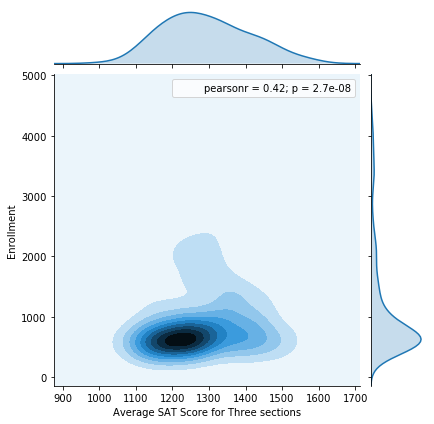

In [55]:
sns.jointplot(x='Average SAT Score for Three sections', y="Enrollment", data=scores, kind='kde')

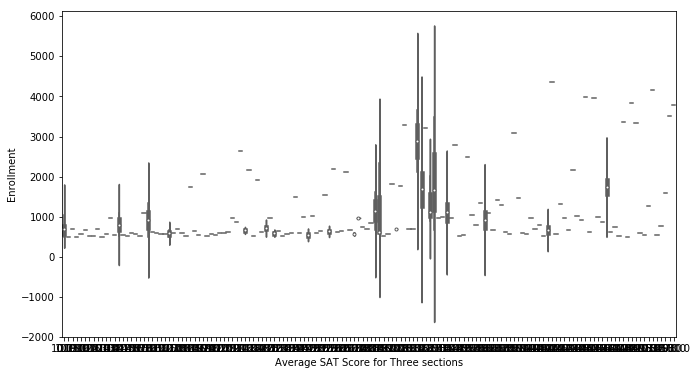

In [140]:
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(x="Average SAT Score for Three sections", y="Enrollment", data=scores, palette="Set3")

In [ ]:
area = satdata.groupby('neighbourhood_group')
nbhood_price = area['price'].agg([np.sum, np.mean, np.std])
nbhood_dist = area['avg_dist'].agg([np.sum, np.mean, np.std])